In [1]:
!pip install wandb

In [25]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import gc
import wandb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import time
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
wandb.login()

wandb: Currently logged in as: nasts2 (sad-bkt). Use `wandb login --relogin` to force relogin


True

# Датасет

In [5]:
batch_size = 64

In [6]:
def data_loader(data_dir, batch_size,random_seed=seed,
                valid_size=0.1,shuffle=True,test=False):
  
    normalize = transforms.Normalize(
        (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
#         mean=[0.4914, 0.4822, 0.4465],
#         std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize,
    ])

    if test:
        dataset = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
        return data_loader

    # load the dataset
    train_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
    valid_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler)
    return (train_loader, valid_loader)


# CIFAR10 dataset 
train_loader, valid_loader = data_loader(data_dir='./data', batch_size=batch_size)

test_loader = data_loader(data_dir='./data', batch_size=batch_size, test=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Модель

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [8]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

Гиперпараметры

In [9]:
num_classes = 10
num_epochs = 10
learning_rate = 0.01
weight_decay = 0.001
momentum = 0.9

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = weight_decay, momentum = momentum)  

In [10]:
wandb.init(project="resnet")
wandb.config = {"learning_rate": learning_rate, 
                "weight_decay": weight_decay,
                "momentum": momentum,
                "epochs": num_epochs, 
                "batch_size": batch_size,
                "classes": num_classes,
                "dataset": "CIFAR10",
                "architecture": "ResNet"}

wandb.watch(model, criterion, log="all", log_freq=10)

[]

In [11]:
%%time

for epoch in range(num_epochs):
    t0 = time.time() 
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print ('Epoch [{}/{}], Loss: {:.4f}, Time: {:.2f}s'.format(epoch+1, num_epochs, loss.item(), time.time() - t0))
    
    # Validation
    list_labels = np.array([])
    list_preds = np.array([])
    
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            list_labels = np.append(list_labels, labels.cpu().numpy())
            list_preds = np.append(list_preds, predicted.cpu().numpy())
            del images, labels, outputs
        
        list_labels = list_labels.astype(int)
        list_preds = list_preds.astype(int)
        
        wandb.log({"epoch": epoch + 1, 
                   "loss": loss.item(),
                   "accuracy ": accuracy_score(list_labels, list_preds),
                   "precision":  precision_score(list_labels, list_preds, average='weighted'),
                   "recall": recall_score(list_labels, list_preds, average='weighted'),
                   "f1": f1_score(list_labels, list_preds, average='weighted')})

Epoch [1/10], Loss: 1.3046, Time: 365.89s
Epoch [2/10], Loss: 1.8509, Time: 368.27s
Epoch [3/10], Loss: 0.6025, Time: 367.36s
Epoch [4/10], Loss: 1.1169, Time: 369.61s
Epoch [5/10], Loss: 0.7205, Time: 368.09s
Epoch [6/10], Loss: 0.4618, Time: 372.30s
Epoch [7/10], Loss: 1.3906, Time: 372.67s
Epoch [8/10], Loss: 0.0862, Time: 373.87s
Epoch [9/10], Loss: 0.6153, Time: 370.29s
Epoch [10/10], Loss: 0.7354, Time: 372.76s
CPU times: user 1h 15min 30s, sys: 7min 29s, total: 1h 22min 59s
Wall time: 1h 4min 13s


# Тестирование

In [12]:
list_labels = []
list_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        list_labels.extend(labels.cpu().numpy())
        list_preds.extend(predicted.cpu().numpy())
        del images, labels, outputs

#     list_labels = list_labels.astype(int)
#     list_preds = list_preds.astype(int)

In [13]:
print(classification_report(list_labels, list_preds))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1000
           1       0.90      0.94      0.92      1000
           2       0.80      0.76      0.78      1000
           3       0.69      0.70      0.70      1000
           4       0.78      0.83      0.80      1000
           5       0.79      0.72      0.76      1000
           6       0.86      0.88      0.87      1000
           7       0.87      0.83      0.85      1000
           8       0.88      0.91      0.89      1000
           9       0.95      0.82      0.88      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



In [19]:
confusion = confusion_matrix(list_labels, list_preds)
total_samples_per_class = confusion.sum(axis=1)
df_metrics = pd.DataFrame(data={
    "Accuracy": confusion.diagonal() / total_samples_per_class,
    "Precision": precision_score(list_labels,  list_preds, average = None),
    "Recall": recall_score(list_labels,  list_preds, average = None),
    "F1 score": f1_score(list_labels,  list_preds, average = None)
})
df_metrics

,Accuracy,Precision,Recall,F1 score
0,0.899,0.794872,0.899,0.843735
1,0.938,0.899329,0.938,0.918257
2,0.758,0.802116,0.758,0.779434
3,0.703,0.688541,0.703,0.695695
4,0.829,0.779135,0.829,0.803295
5,0.725,0.793217,0.725,0.757576
6,0.882,0.859649,0.882,0.870681
7,0.833,0.869520,0.833,0.850868
8,0.908,0.875603,0.908,0.891507
9,0.818,0.950058,0.818,0.879097


In [29]:
print("Accuracy", accuracy_score(list_labels,  list_preds))
print("Precision", precision_score(list_labels,  list_preds, average='weighted'))
print("Recall", recall_score(list_labels,  list_preds, average='weighted'))
print("F1 score", f1_score(list_labels,  list_preds, average='weighted'))

Accuracy 0.8293
Precision 0.8312039398914601
Recall 0.8293
F1 score 0.8290146534805337


<Axes: >

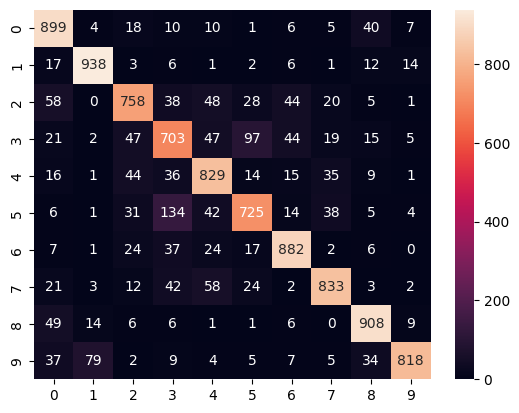

In [22]:
sns.heatmap(confusion, annot=True, fmt='g')

In [23]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

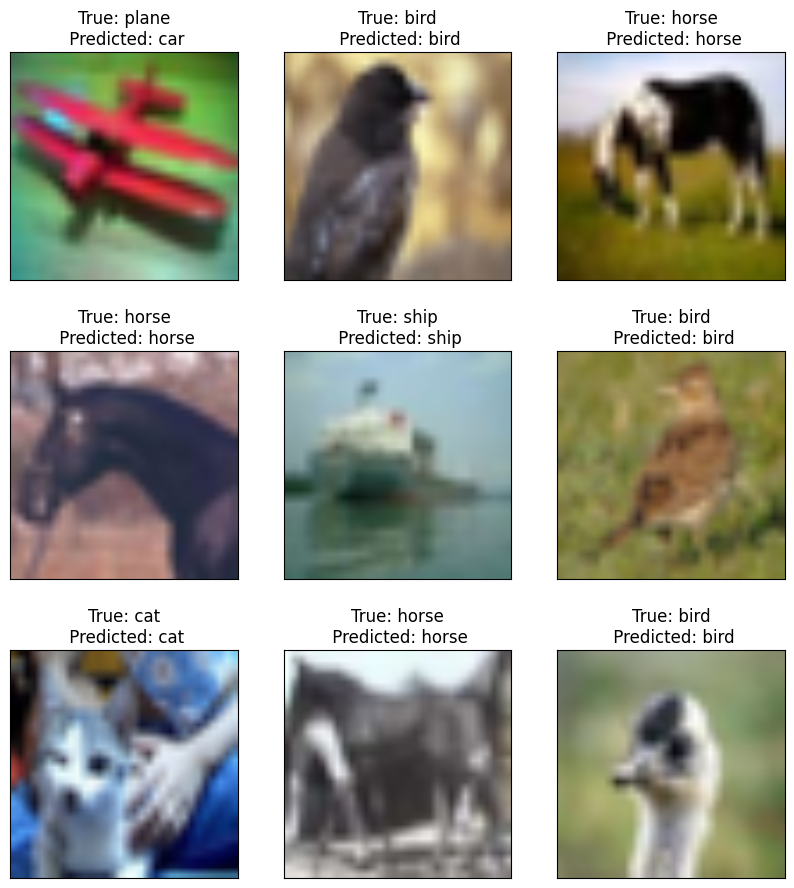

In [42]:
fig = plt.figure(figsize=(10, 11))
for i in range(9):
    images, labels = next(iter(test_loader))
    with torch.no_grad():
        #images1 = images.to(device)
        #labels1 = labels.to(device)
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
        single_image = np.transpose(np.array(images[0].to('cpu')), (1,2,0))
        plt.imshow(single_image/2 + 0.5)
        ax.set_title(f"True: {classes[labels[0].item()]}\n Predicted: {classes[predicted[0].item()]}")
        del images, labels, outputs
    
plt.show()

In [43]:
wandb.finish()

accuracy,▁▅▇▇▇█▇███
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▅▇▇▇█▇███
loss,▆█▃▅▄▂▆▁▃▄
precision,▁▅▇▇▇█▇███
recall,▁▅▇▇▇█▇███
accuracy,0.8334
epoch,10
f1,0.83337
loss,0.73535
precision,0.83696
